In [1]:
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('drive/My Drive/Colab Notebooks/DigData')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Lloyds Bank live online DigData career challenge.**


**Challenge Overview:**

**Lloyds Banking Group is launching a new loans product. Prior to 
the launch they would like you to use historical customer data to:**
- **Task 1 – Data Strategy : Understand and summarise the 
different behaviours or attributes between customers who 
paid back their loan and customers who did not.**

- **Task 2 – Data Science: To use the historical data to design a 
process which predicts the likelihood of a new customer not 
paying back their loan.** 

**Import libraries.**

In [2]:
## data
import numpy as np
import pandas as pd

## visualisations

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale = 1.5)

## ignore warnings
import warnings
warnings.filterwarnings("ignore",module = "matplotlib\..*")

## sklearn
import scipy
from sklearn import preprocessing
from sklearn.preprocessing import FunctionTransformer, minmax_scale
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics
from sklearn.metrics import make_scorer, balanced_accuracy_score, f1_score,  precision_score, recall_score, confusion_matrix,classification_report,PrecisionRecallDisplay
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import kelbow_visualizer

## shap
!pip install shap
import shap

## basic models
!pip install lazypredict
from lazypredict.Supervised import LazyClassifier

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Load the data.**

In [3]:
## Load data
data = pd.read_excel('LBG Step Up Data Set.xlsx')
#data = data.drop('Unnamed: 0',axis=1)
data.head()

,id,addr_state,annual_inc,emp_length,emp_title,home_ownership,installment,loan_amnt,purpose,term,...,num_il_tl,num_op_rev_tl,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc,percent_bc_gt_75,pub_rec_bankruptcies,total_acc,total_bal_ex_mort,loan_status
0,802173,CA,72000.00,3 years,CA. Dept. Of Corrections,MORTGAGE,395.66,12000,debt_consolidation,36 months,...,NaN,NaN,NaN,NaN,16,NaN,0,23,NaN,Fully Paid
1,14518910,TX,97500.00,1 year,Curriculum & Implementation Manager,RENT,966.47,35000,debt_consolidation,60 months,...,2.00,12.00,0.00,1.00,13,87.50,0,24,84227.00,Fully Paid
2,54333324,NY,120000.00,1 year,Senior manager,RENT,806.57,25000,credit_card,36 months,...,2.00,7.00,0.00,1.00,8,100.00,0,16,39124.00,Fully Paid
3,62247022,CA,130000.00,10+ years,Border Patrol Agent,RENT,846.17,25225,debt_consolidation,36 months,...,9.00,3.00,0.00,2.00,8,50.00,0,24,123331.00,Fully Paid
4,71986114,TX,58296.00,10+ years,Account Manager,MORTGAGE,41.79,1200,other,36 months,...,7.00,6.00,0.00,0.00,9,100.00,0,17,51794.00,Fully Paid


In [4]:
print(f'Our dataset has a shape of: {data.shape}')

Our dataset has a shape of: (18324, 31)


- **We have a dataset with $18324$ entries and $31$ features. Let's take a look at the name, data type, and description of each feature.**

In [5]:
description = pd.read_excel('LBG Step Up Data Dictionary.xlsx')
description.drop(columns=['Unnamed: 0','Unnamed: 1','Unnamed: 4'],axis=1,inplace=True)
row_drop_list = np.arange(15).tolist()
description.drop(row_drop_list,inplace=True)
description.rename(columns={'Unnamed: 2': 'Field Name', 
                     'Unnamed: 3':'Data Type',
                     'Unnamed: 5':'Description',
                     },inplace=True)
description

,Field Name,Data Type,Description
15,id,Unique Identifer,A unique ID for the loan listing.
16,addr_state,Categoric Variable,The US state provided by the borrower in the l...
17,annual_inc,Numeric Variable,The annual income provided by the borrower dur...
18,emp_length,Categoric Variable,Employment length in years. Possible values ar...
19,emp_title,Categoric Variable,The job title supplied by the Borrower when ap...
20,home_ownership,Categoric Variable,The home ownership status provided by the borr...
21,installment,Numeric Variable,The monthly payment owed by the borrower if th...
22,loan_amnt,Numeric Variable,The listed amount of the loan applied for by t...
23,purpose,Categoric Variable,A category provided by the borrower for the lo...
24,term,Categoric Variable,The number of payments on the loan. Values are...


**Let's begin with the data cleansing.**

**First of all, do we indeed have $18324$ unique customers?**

In [6]:
id = 'id'
print(f'There are {data[id].nunique()} unique customers.')

There are 18324 unique customers.


**Yes, that looks good. Let's drop the `id' column since it does not provide any other information.**

In [7]:
data.drop('id',axis=1,inplace=True)

**Let's check for missing values and the attributes' data type.**

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18324 entries, 0 to 18323
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   addr_state              18324 non-null  object 
 1   annual_inc              18324 non-null  float64
 2   emp_length              17150 non-null  object 
 3   emp_title               17042 non-null  object 
 4   home_ownership          18324 non-null  object 
 5   installment             18324 non-null  float64
 6   loan_amnt               18324 non-null  int64  
 7   purpose                 18324 non-null  object 
 8   term                    18324 non-null  object 
 9   int_rate                18324 non-null  float64
 10  avg_cur_bal             17758 non-null  float64
 11  inq_last_12m            9395 non-null   float64
 12  max_bal_bc              9395 non-null   float64
 13  mo_sin_old_il_acct      17192 non-null  float64
 14  mo_sin_old_rev_tl_op    17760 non-null

- **There are quite a few features with missing values or/and the wrong data type. Let's take a closer look.**

In [9]:
## percentage of missing values of each feature
na_per = (data.isnull().sum())*100 / data.shape[0]
features_wmv = []
## print the column names and percentage of missing values
for i,j in enumerate(na_per):
  if j>0:
    features_wmv.append(data.columns[i]) ## store the features with missing values
    print(f'Feature {data.columns[i]} consists of  {round(j,2)}% missing values.')
    print('-----------------------------------------------------------------------------')

Feature emp_length consists of  6.41% missing values.
-----------------------------------------------------------------------------
Feature emp_title consists of  7.0% missing values.
-----------------------------------------------------------------------------
Feature avg_cur_bal consists of  3.09% missing values.
-----------------------------------------------------------------------------
Feature inq_last_12m consists of  48.73% missing values.
-----------------------------------------------------------------------------
Feature max_bal_bc consists of  48.73% missing values.
-----------------------------------------------------------------------------
Feature mo_sin_old_il_acct consists of  6.18% missing values.
-----------------------------------------------------------------------------
Feature mo_sin_old_rev_tl_op consists of  3.08% missing values.
-----------------------------------------------------------------------------
Feature mo_sin_rcnt_rev_tl_op consists of  3.08% missin

- **Most features with missing values have around $2-3$% of missing values.**
- **emp_length, emp_title, and mo_sin_old_il_acct have around $6-7$% of missing values.**
- **inq_last_12m, max_bal_bc, and mths_since_last_delinq have around $48-49$% of missing values.**

In [10]:
## Data cleaning

data['annual_inc'] = data['annual_inc'].astype(int)
data['home_ownership'] = data['home_ownership'].str.replace("ANY","OTHER")

## strip whitespace 
data['emp_length'] = data['emp_length'].str.replace("< 1 year","0")
data['emp_length'] = data['emp_length'].str.replace("( ).*","")
data['emp_length'] = data['emp_length'].str.replace("+","")


## strip whitespace 
data['term'] = data['term'].str.strip()
data['term'] = data['term'].str.replace("( ).*","")

## float to integer
cols_f2i = ['inq_last_12m', 'avg_cur_bal', 'max_bal_bc', 'mo_sin_old_il_acct',
            'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
            'mort_acc','mths_since_last_delinq', 'num_bc_tl', 'num_il_tl',
            'num_op_rev_tl', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
            'total_bal_ex_mort']

for col in cols_f2i:
  data[col] = pd.to_numeric(data[col], errors='coerce').convert_dtypes()

In [11]:
## Missing values 
emp_length = 'emp_length'
emp_title = 'emp_title'
loan_status = 'loan_status'
print(f'There are {data[emp_length].isna().sum()} and {data[emp_title].isna().sum()} missing values in the emp_length and emp_title columns respectively.')
print(f'There are {data[data[emp_length].isnull()][emp_title].isna().sum()} missing values in both the emp_length and emp_title columns.')

There are 1174 and 1282 missing values in the emp_length and emp_title columns respectively.
There are 1169 missing values in both the emp_length and emp_title columns.


- **It seems that 'emp_length' and 'emp_title' share most of their missing values. Customers who don't want to say what their job is, will possibly don't want to disclose their employment length either.**

Feature: emp_length


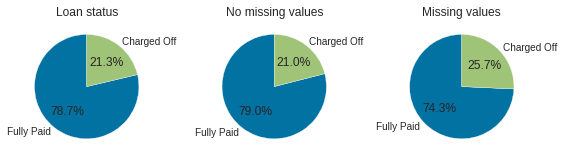


Feature: emp_title


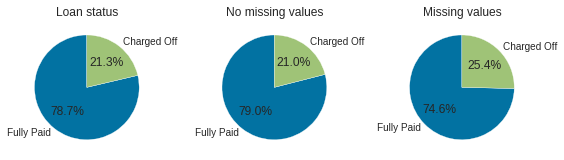


Feature: avg_cur_bal


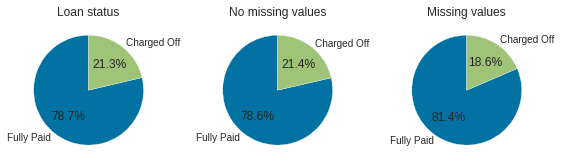


Feature: inq_last_12m


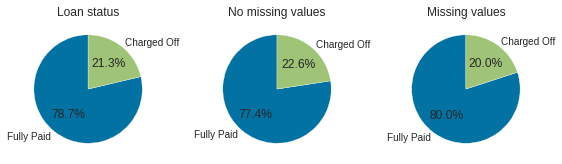


Feature: max_bal_bc


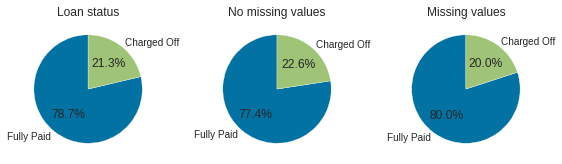


Feature: mo_sin_old_il_acct


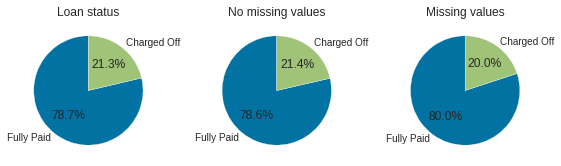


Feature: mo_sin_old_rev_tl_op


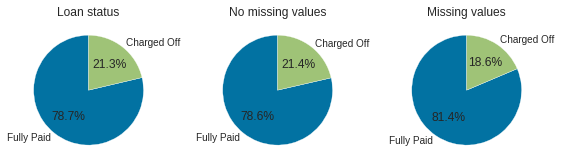


Feature: mo_sin_rcnt_rev_tl_op


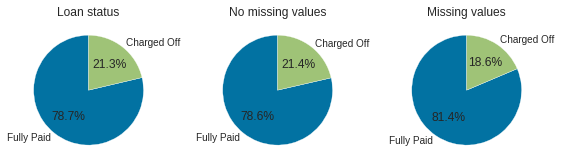


Feature: mo_sin_rcnt_tl


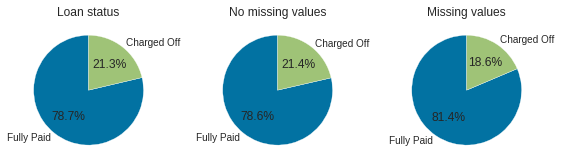


Feature: mort_acc


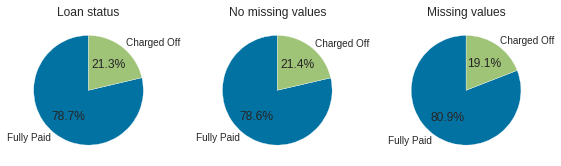


Feature: mths_since_last_delinq


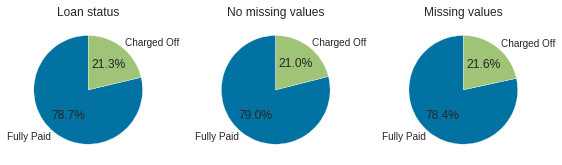


Feature: num_bc_tl


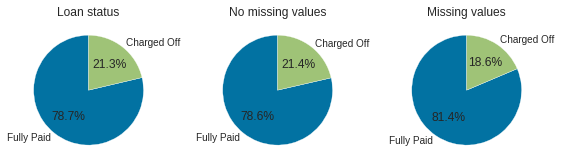


Feature: num_il_tl


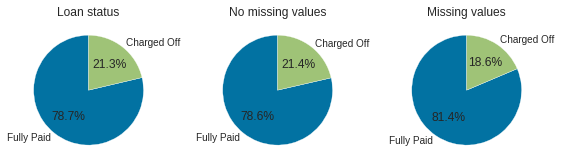


Feature: num_op_rev_tl


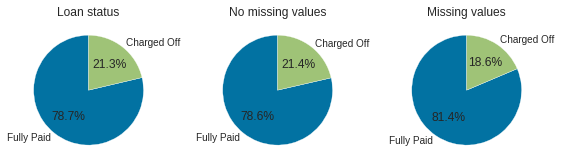


Feature: num_tl_90g_dpd_24m


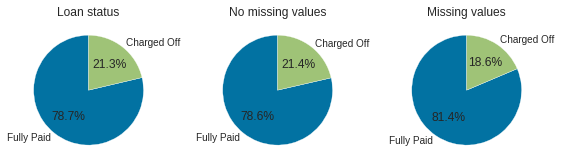


Feature: num_tl_op_past_12m


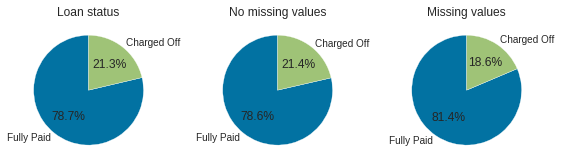


Feature: percent_bc_gt_75


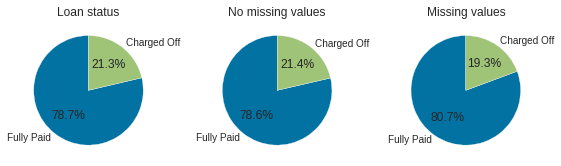


Feature: total_bal_ex_mort


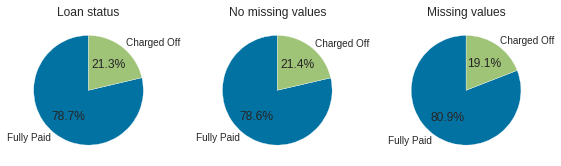

In [12]:
labels = data['loan_status'].unique()

for col in features_wmv:
    print(f'Feature: {col}')
    fig, axes = plt.subplots(1, 3, figsize=(8, 8))

    g1 = axes[0].pie(data['loan_status'].value_counts(), labels = labels, startangle = 90,autopct='%1.1f%%')
    axes[0].set_title('Loan status')

    g2 = axes[1].pie(data[data[col].notnull()][loan_status].value_counts(), labels = labels, startangle = 90,autopct='%1.1f%%')
    axes[1].set_title('No missing values')

    g3 = axes[2].pie(data[data[col].isnull()][loan_status].value_counts(), labels = labels, startangle = 90,autopct='%1.1f%%')
    axes[2].set_title('Missing values')

    plt.tight_layout()
    plt.show() 
    print()

- **Customers with missing job title and employment length have a higher percentage of not paying their loan than those who disclose these information.
We fill the missing values with 'Unknown' for the job title.**

- **Missing number of credit inquiries, maximum current balance owed on all revolving accounts, and missed payments probably imply that there are none.
We fill the missing values with zeros.**

- **For the rest features we just remove the missing values. There is only a $2-3$% of missing values.**

In [13]:
data.dropna(subset=['avg_cur_bal','mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op','emp_length',
                 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl','num_bc_tl', 'num_il_tl',
                 'num_op_rev_tl', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 
                 'percent_bc_gt_75', 'total_bal_ex_mort'],inplace=True)

data['emp_title'].fillna('Unknown',inplace=True)

[data[col].fillna(0, inplace=True) for col in ['inq_last_12m', 'max_bal_bc', 'mths_since_last_delinq'] ]


for col in cols_f2i:
  data[col] = data[col].astype(int)

In [14]:
data.head()

,addr_state,annual_inc,emp_length,emp_title,home_ownership,installment,loan_amnt,purpose,term,int_rate,...,num_il_tl,num_op_rev_tl,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc,percent_bc_gt_75,pub_rec_bankruptcies,total_acc,total_bal_ex_mort,loan_status
1,TX,97500,1,Curriculum & Implementation Manager,RENT,966.47,35000,debt_consolidation,60,0.22,...,2,12,0,1,13,87.50,0,24,84227,Fully Paid
2,NY,120000,1,Senior manager,RENT,806.57,25000,credit_card,36,0.10,...,2,7,0,1,8,100.00,0,16,39124,Fully Paid
3,CA,130000,10,Border Patrol Agent,RENT,846.17,25225,debt_consolidation,36,0.13,...,9,3,0,2,8,50.00,0,24,123331,Fully Paid
4,TX,58296,10,Account Manager,MORTGAGE,41.79,1200,other,36,0.15,...,7,6,0,0,9,100.00,0,17,51794,Fully Paid
5,VA,87000,0,Supply Tech,RENT,629.47,24000,credit_card,60,0.20,...,12,19,0,6,24,77.80,0,42,50912,Charged Off


In [15]:
data.shape

(15955, 30)

- **Next, we check the data for consistency between the features and then do some feature engineering.**

In [16]:
d_c = pd.DataFrame()
d_c['term'] = data['term']
d_c['term'] = pd.to_numeric(d_c['term'], errors='coerce').convert_dtypes() 
d_c['term'] = d_c['term'].astype(int)

In [17]:
## Check 1.
## installment can't be greater than the loan amount
if data[data['installment'] >= data['loan_amnt']].shape[0] == 0:
  print('Pass.')
else:
  print('Fail.')

## Check 2.
## monthly income must be greater than monthly installment
if data[data['annual_inc']/12 <= data['installment']].shape[0] == 0:
  print('Pass.')
else:
  print('Fail.')

## Check 3.
## Installment * term should be equal to Loan amount + Loan amount*interest rate
if np.sum(data['installment'] * d_c['term'] == data['loan_amnt'] + data['loan_amnt']*data['int_rate']) != 0:
     print('Pass.')
else:
  print('Fail.')

## Check 4.
## months since most recent revolving acc opened must be fewer than months since oldest revolving acc opened
if np.sum(data['mo_sin_old_rev_tl_op'] < data['mo_sin_rcnt_rev_tl_op']) ==0:
  print('Pass.')
else:
  print('Fail.')

Pass.
Pass.
Fail.
Pass.


In [18]:
## fix interest rate col
data['int_rate'] = ((data['installment'] * d_c['term'])-data['loan_amnt'])/data['loan_amnt']

## customer either missed a(multiple) payment(s) or not
data.loc[data['mths_since_last_delinq'] !=0,'mths_since_last_delinq']=1

## rename 
data.rename(columns={'mths_since_last_delinq':'missed payment'},inplace=True)

## Length of credit history col
data['Length of credit history'] = 0
for i in range(data.shape[0]):
  if data['mo_sin_old_il_acct'].iloc[i] > data['mo_sin_old_rev_tl_op'].iloc[i]:
    data['Length of credit history'].iloc[i] = data['mo_sin_old_il_acct'].iloc[i]
  else:
    data['Length of credit history'].iloc[i] = data['mo_sin_old_rev_tl_op'].iloc[i]

## Total accounts col + drop individual acc cols
data['total accounts'] = data['num_bc_tl'] + data['num_il_tl'] + data['num_op_rev_tl'] + data['mort_acc']
data.drop(columns=['mo_sin_old_il_acct','mo_sin_old_rev_tl_op','num_bc_tl','num_il_tl','num_op_rev_tl','mort_acc'],axis=1,inplace=True)

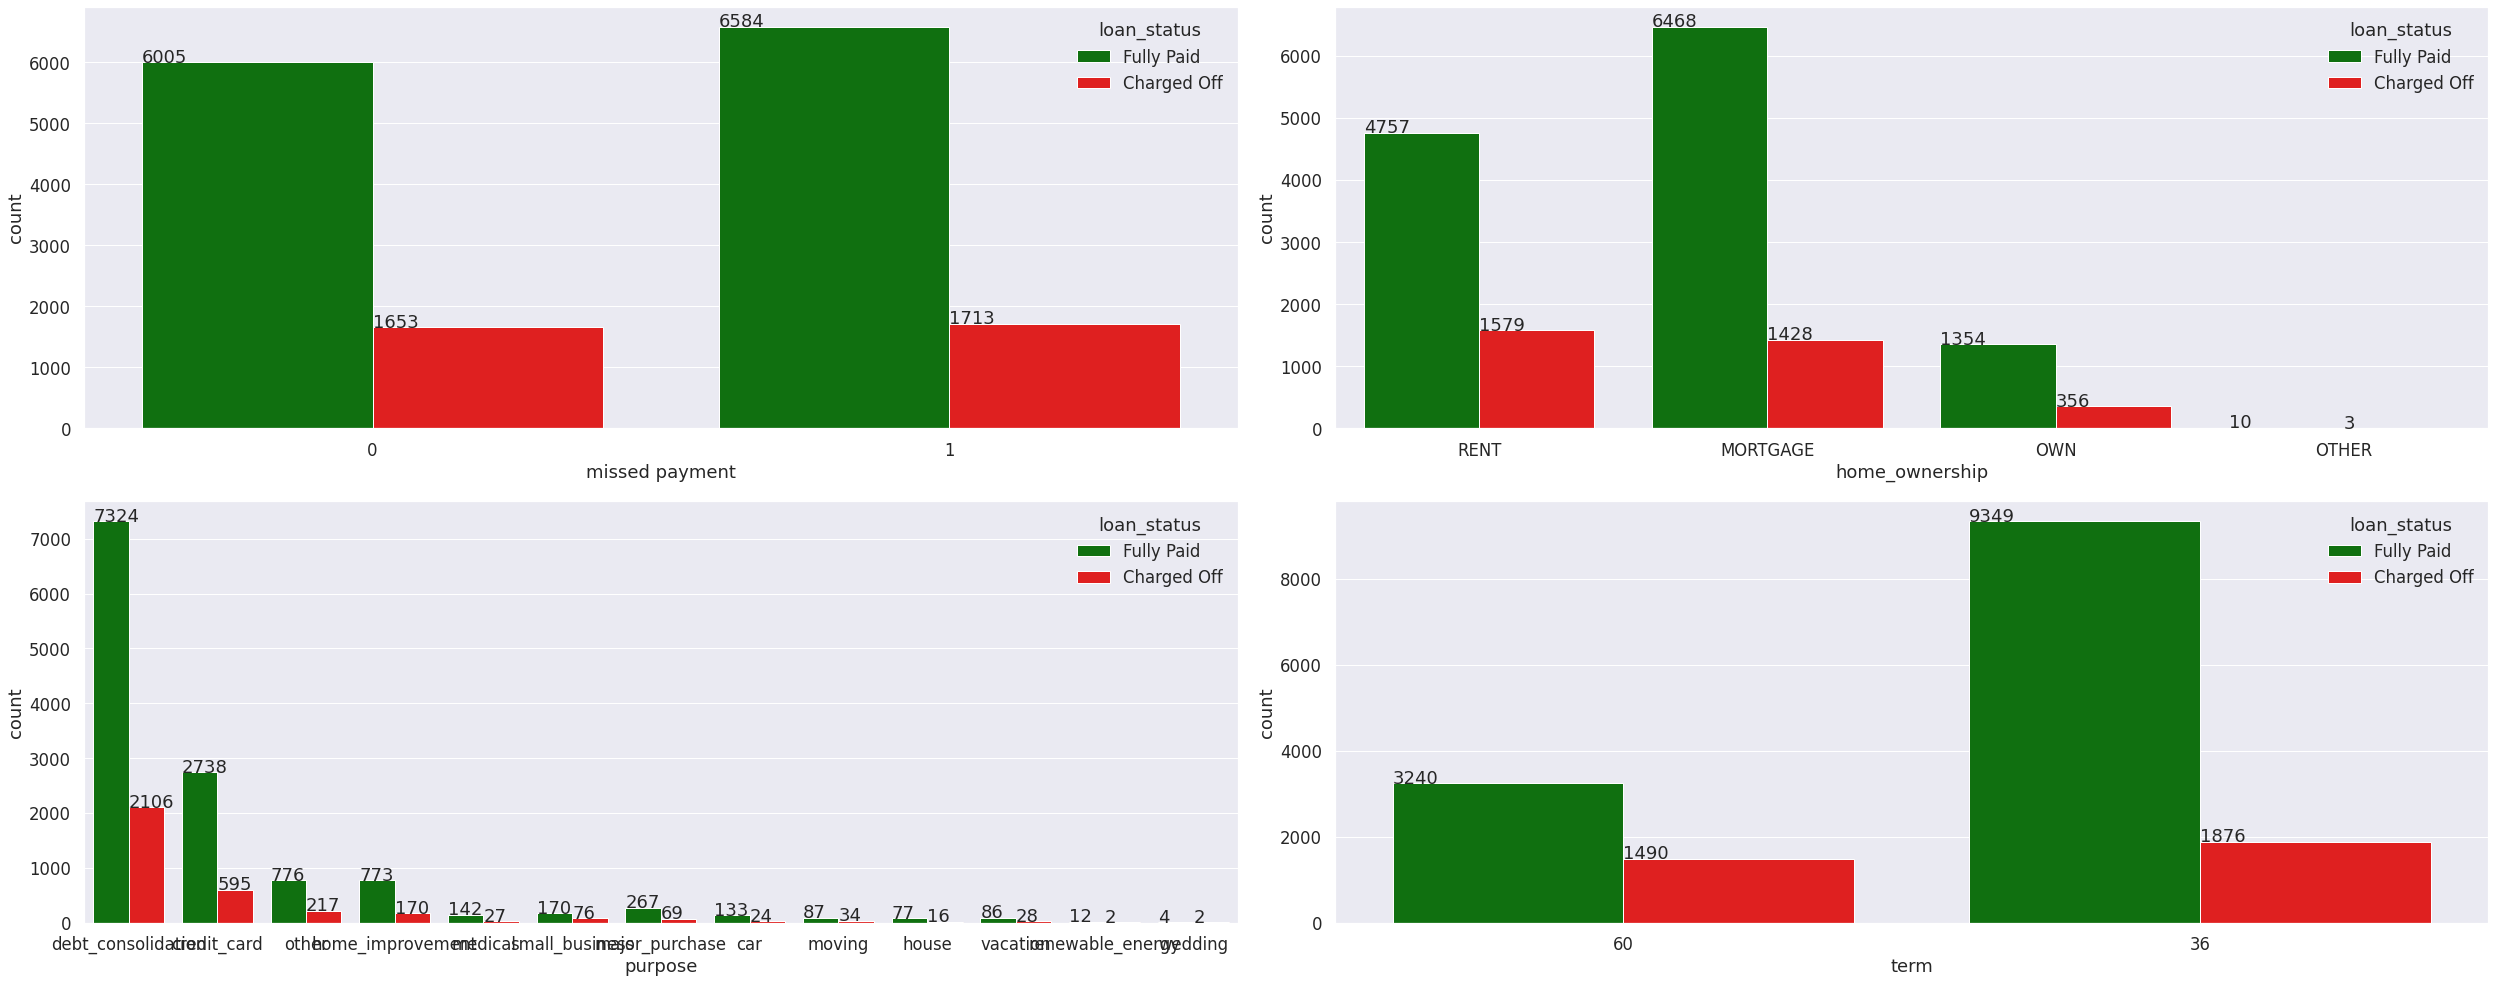

In [19]:
sns.set(font_scale = 1.5)
plt.figure(figsize=(35,14))
i=1
for col in ['missed payment','home_ownership','purpose','term']:
  ax = plt.subplot(2,2,i)
  g=sns.countplot(x=col,data=data,hue='loan_status', palette=['green','red'])
  for p in g.patches:
      txt = str(p.get_height().round(2))
      txt_x = p.get_x() 
      txt_y = p.get_height()
      g.text(txt_x,txt_y,txt)
  i+=1
plt.tight_layout()
plt.show()


- **The only takeaway here is that customers with $60$ payments on the loan default much more often than those with $36$ payments on the loan.
(will term play a more significant role on predicting who will default later than the other features? We will see.)**

- **Let's split the features into numerical and categorical.**

In [20]:
## categorical and numerical features

categorical_features = []
numerical_features = []
for col in data.columns:
  if data[col].dtype == 'object':
    categorical_features.append(col)
  else:
      numerical_features.append(col)
print(f'Categorical features: {categorical_features}')
print(f'Numerical features: {numerical_features}')

Categorical features: ['addr_state', 'emp_length', 'emp_title', 'home_ownership', 'purpose', 'term', 'loan_status']
Numerical features: ['annual_inc', 'installment', 'loan_amnt', 'int_rate', 'avg_cur_bal', 'inq_last_12m', 'max_bal_bc', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'missed payment', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'open_acc', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'total_acc', 'total_bal_ex_mort', 'Length of credit history', 'total accounts']


**Numerical Features.**

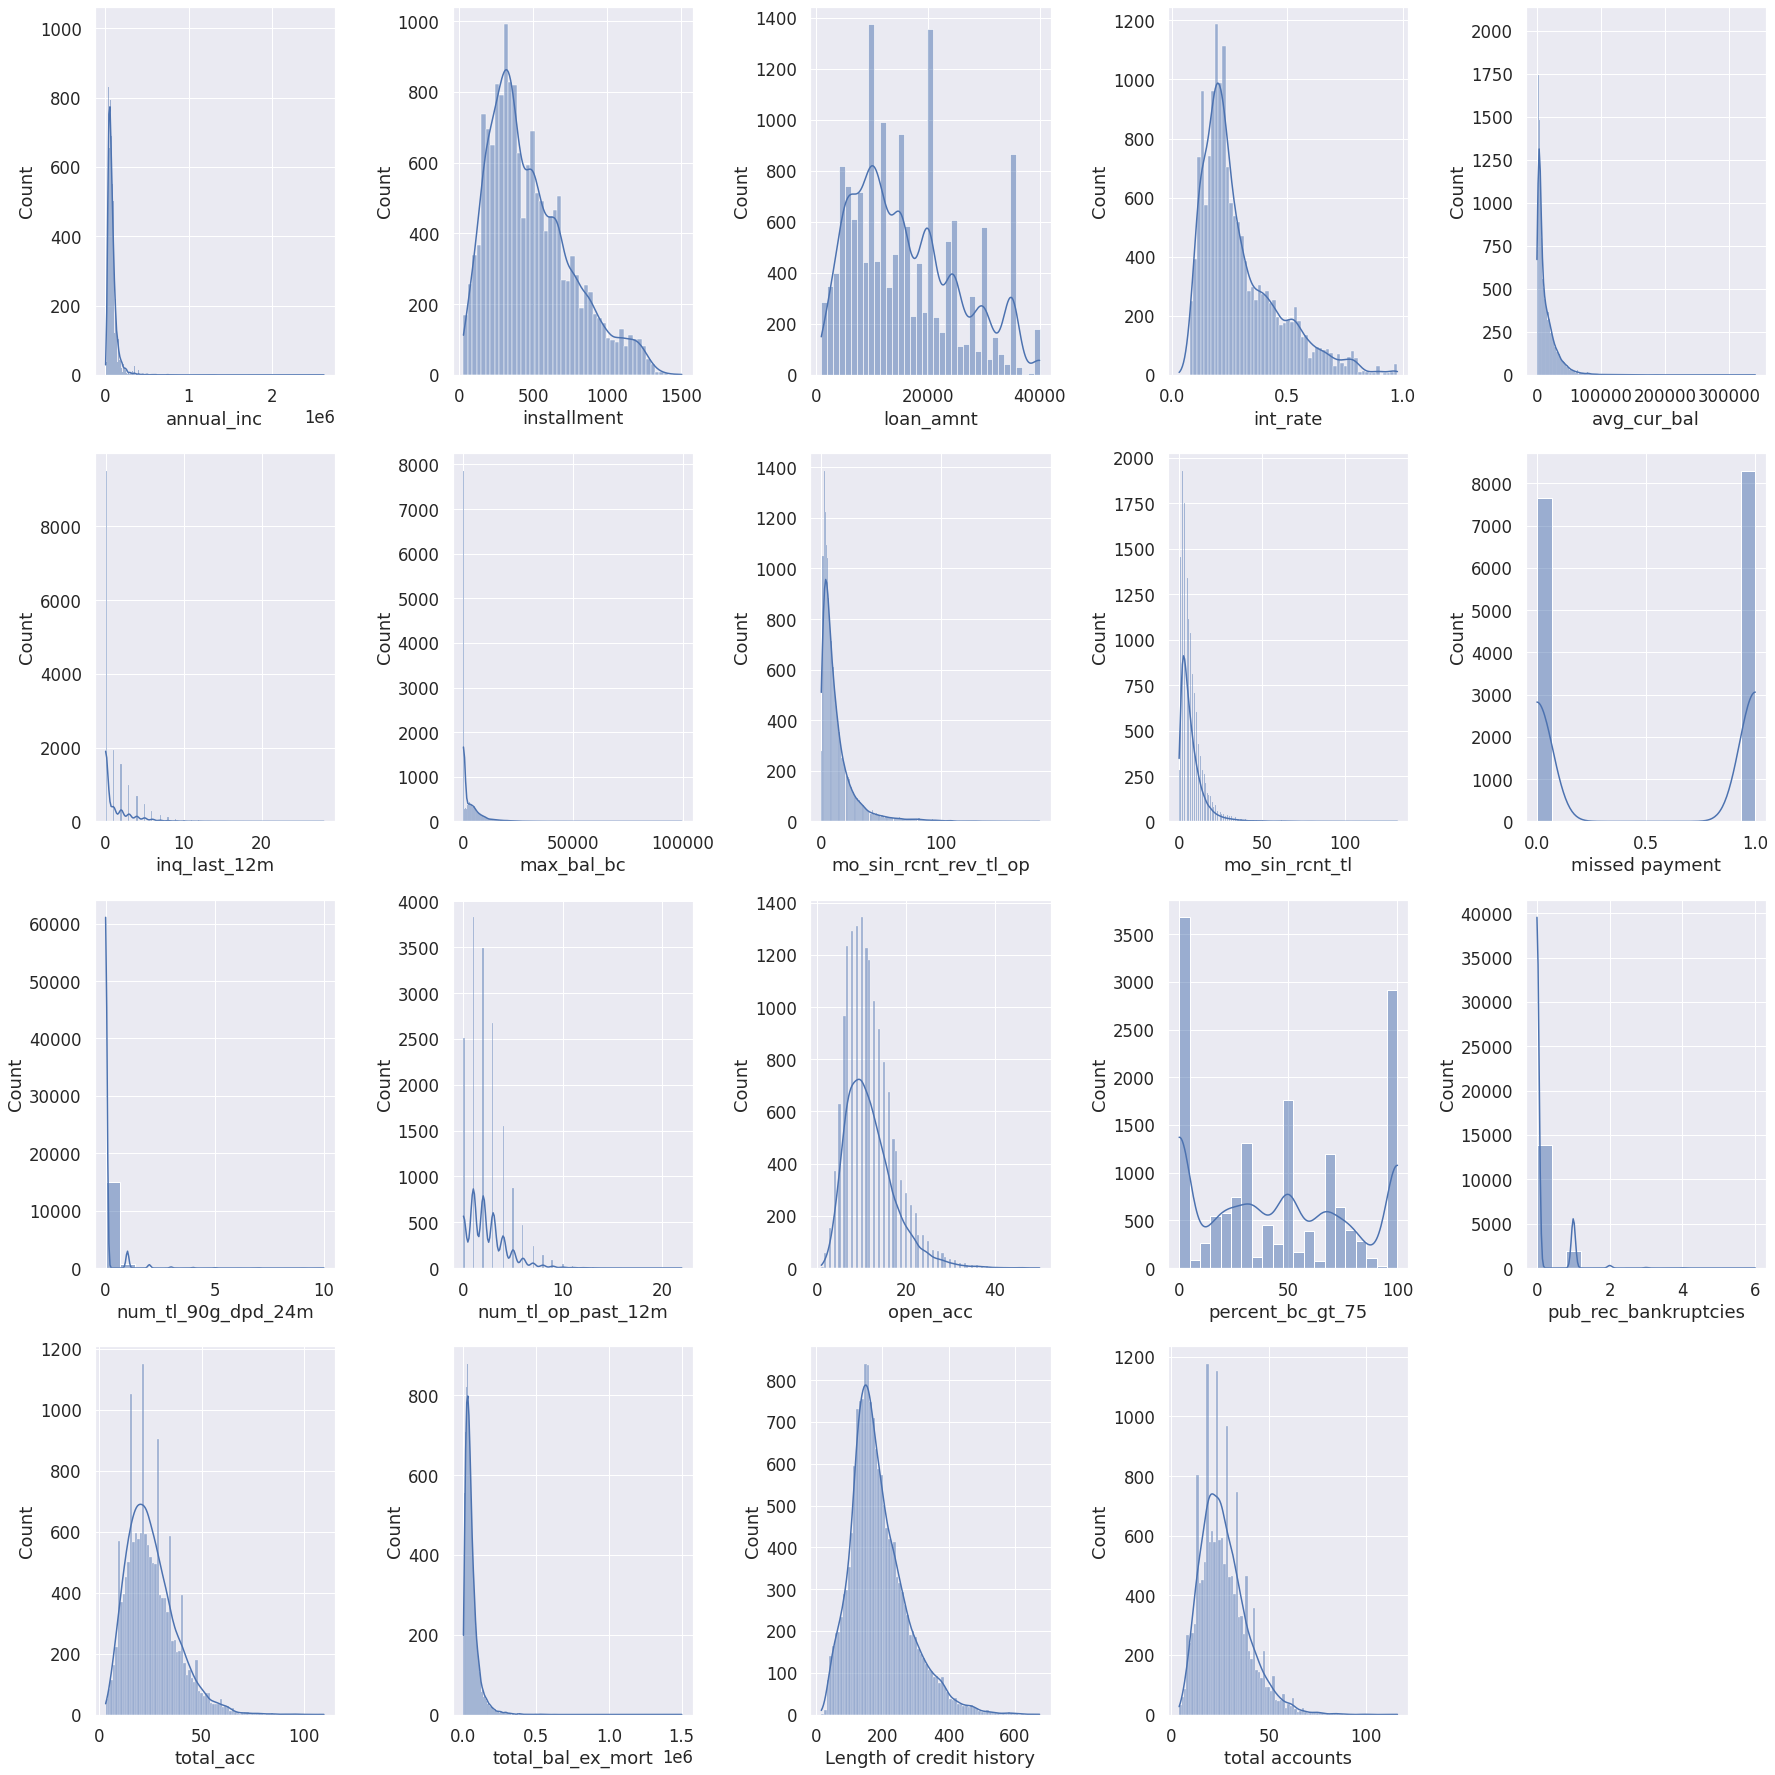

In [21]:
## distributions
plt.figure(figsize=(25,25))
i = 1 
for col in numerical_features:
  ax = plt.subplot(4,5,i)
  sns.histplot(data=data, x=col, kde=True)
  i+=1
plt.tight_layout()
plt.show()

- **Most features' distributions are right skewed.**
- **The scale of the features seem to be quite different.**

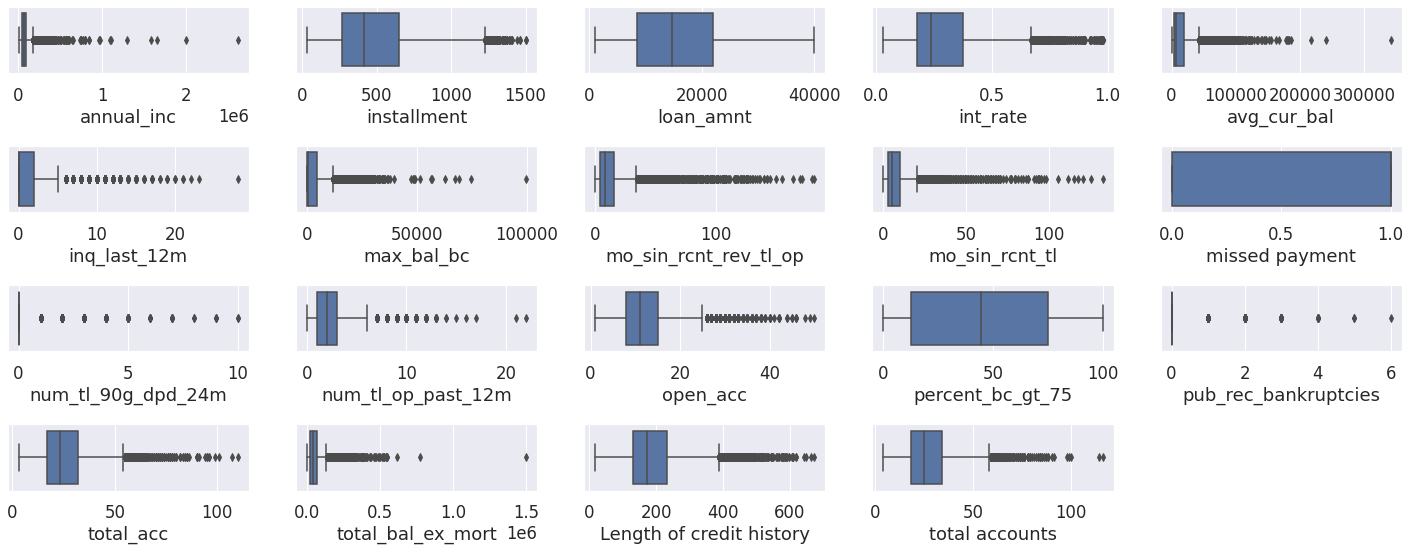

In [22]:
## boxplots
plt.figure(figsize=(20,8))
i=1
for col in numerical_features:
  ax = plt.subplot(4,5,i)
  sns.boxplot(data=data,x=col)
  i+=1
plt.tight_layout()
plt.show()

- **Most features have many outliers.**
- **However, outliers may contain some important information in our problem's context, so we will keep them.**

**Categorical Features.**

In [23]:
for col in categorical_features:
  print(f'Column: {col}')
  print('----------------------')
  print(data[col].value_counts())
  print('-----------------------------------')
  print('-----------------------------------')

Column: addr_state
----------------------
CA    2286
TX    1345
NY    1294
FL    1135
IL     618
NJ     558
PA     546
GA     517
OH     492
VA     434
NC     432
MI     400
AZ     399
MD     356
MA     355
CO     349
WA     348
MO     289
TN     271
MN     271
IN     269
NV     248
AL     219
CT     212
LA     210
WI     205
SC     199
OR     182
KY     155
OK     150
KS     119
UT     117
AR     100
NM      97
MS      96
HI      81
NH      70
RI      59
DE      57
NE      56
WV      55
MT      48
VT      43
DC      36
ME      34
SD      34
WY      32
ND      31
AK      29
ID      16
IA       1
Name: addr_state, dtype: int64
-----------------------------------
-----------------------------------
Column: emp_length
----------------------
10    5852
2     1512
0     1317
3     1290
1     1105
5     1024
4      978
6      767
8      751
7      746
9      613
Name: emp_length, dtype: int64
-----------------------------------
-----------------------------------
Column: emp_title
----------

- **There are 9235 unique job titles. We will seperate the 'emp_title' column into those who disclosed their job title and those who did not.**

In [24]:
data['emp_title'].replace({'Unknown' : '0'}, inplace=True)
data.loc[data['emp_title'] != '0', 'emp_title'] = '1'
data['emp_title'] = pd.to_numeric(data['emp_title'], errors='coerce').convert_dtypes() 
data['emp_title'] = data['emp_title'].astype(int)

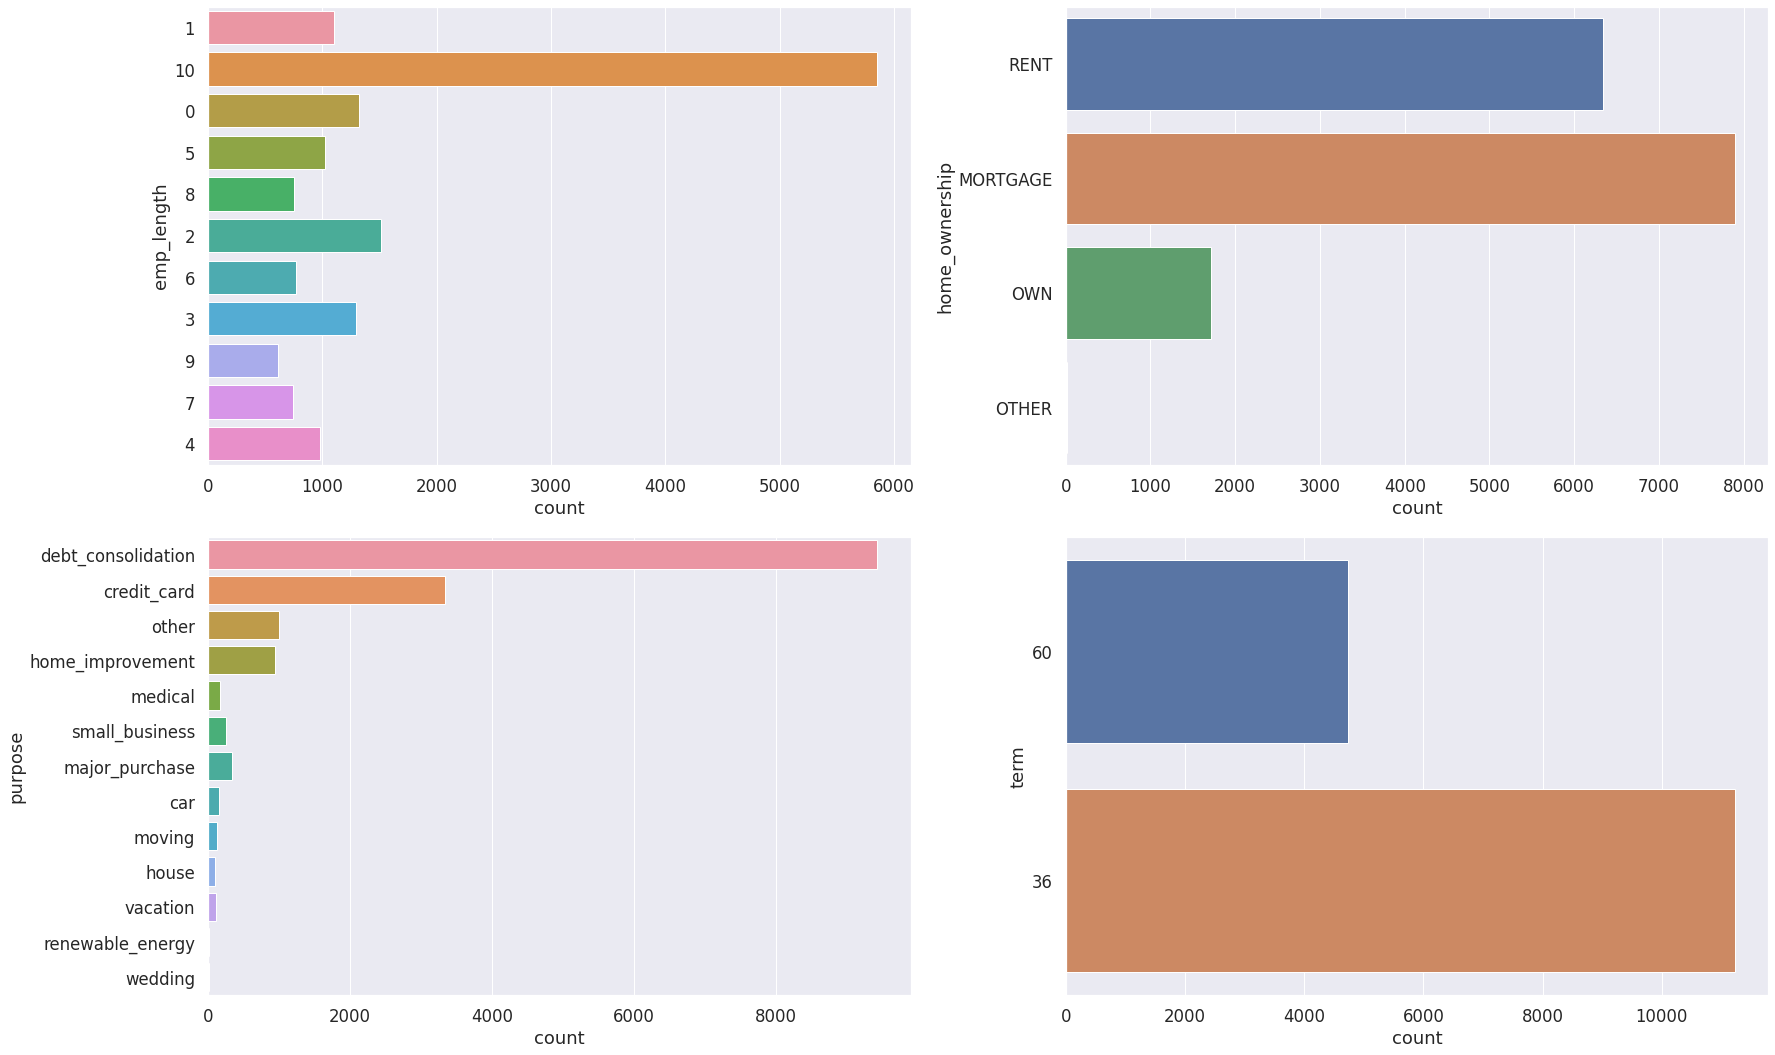

In [25]:
## countplots of categorical features

plt.figure(figsize=(25,15))
i=1
for col in ['emp_length','home_ownership', 'purpose', 'term']:
	ax1 = plt.subplot(2,2,i)
	sns.countplot(y=col,data=data)
	i += 1
plt.tight_layout()
plt.show()

- **The employment length of most customers is 10 or more years.**
- **Most customers take a loan for debt consolidation.**
- **Most customers eith rent a home or have a mortgage.**
- **Most customers have $36$ payments on their loan.**

**Correlation analysis (bivariate analysis)**

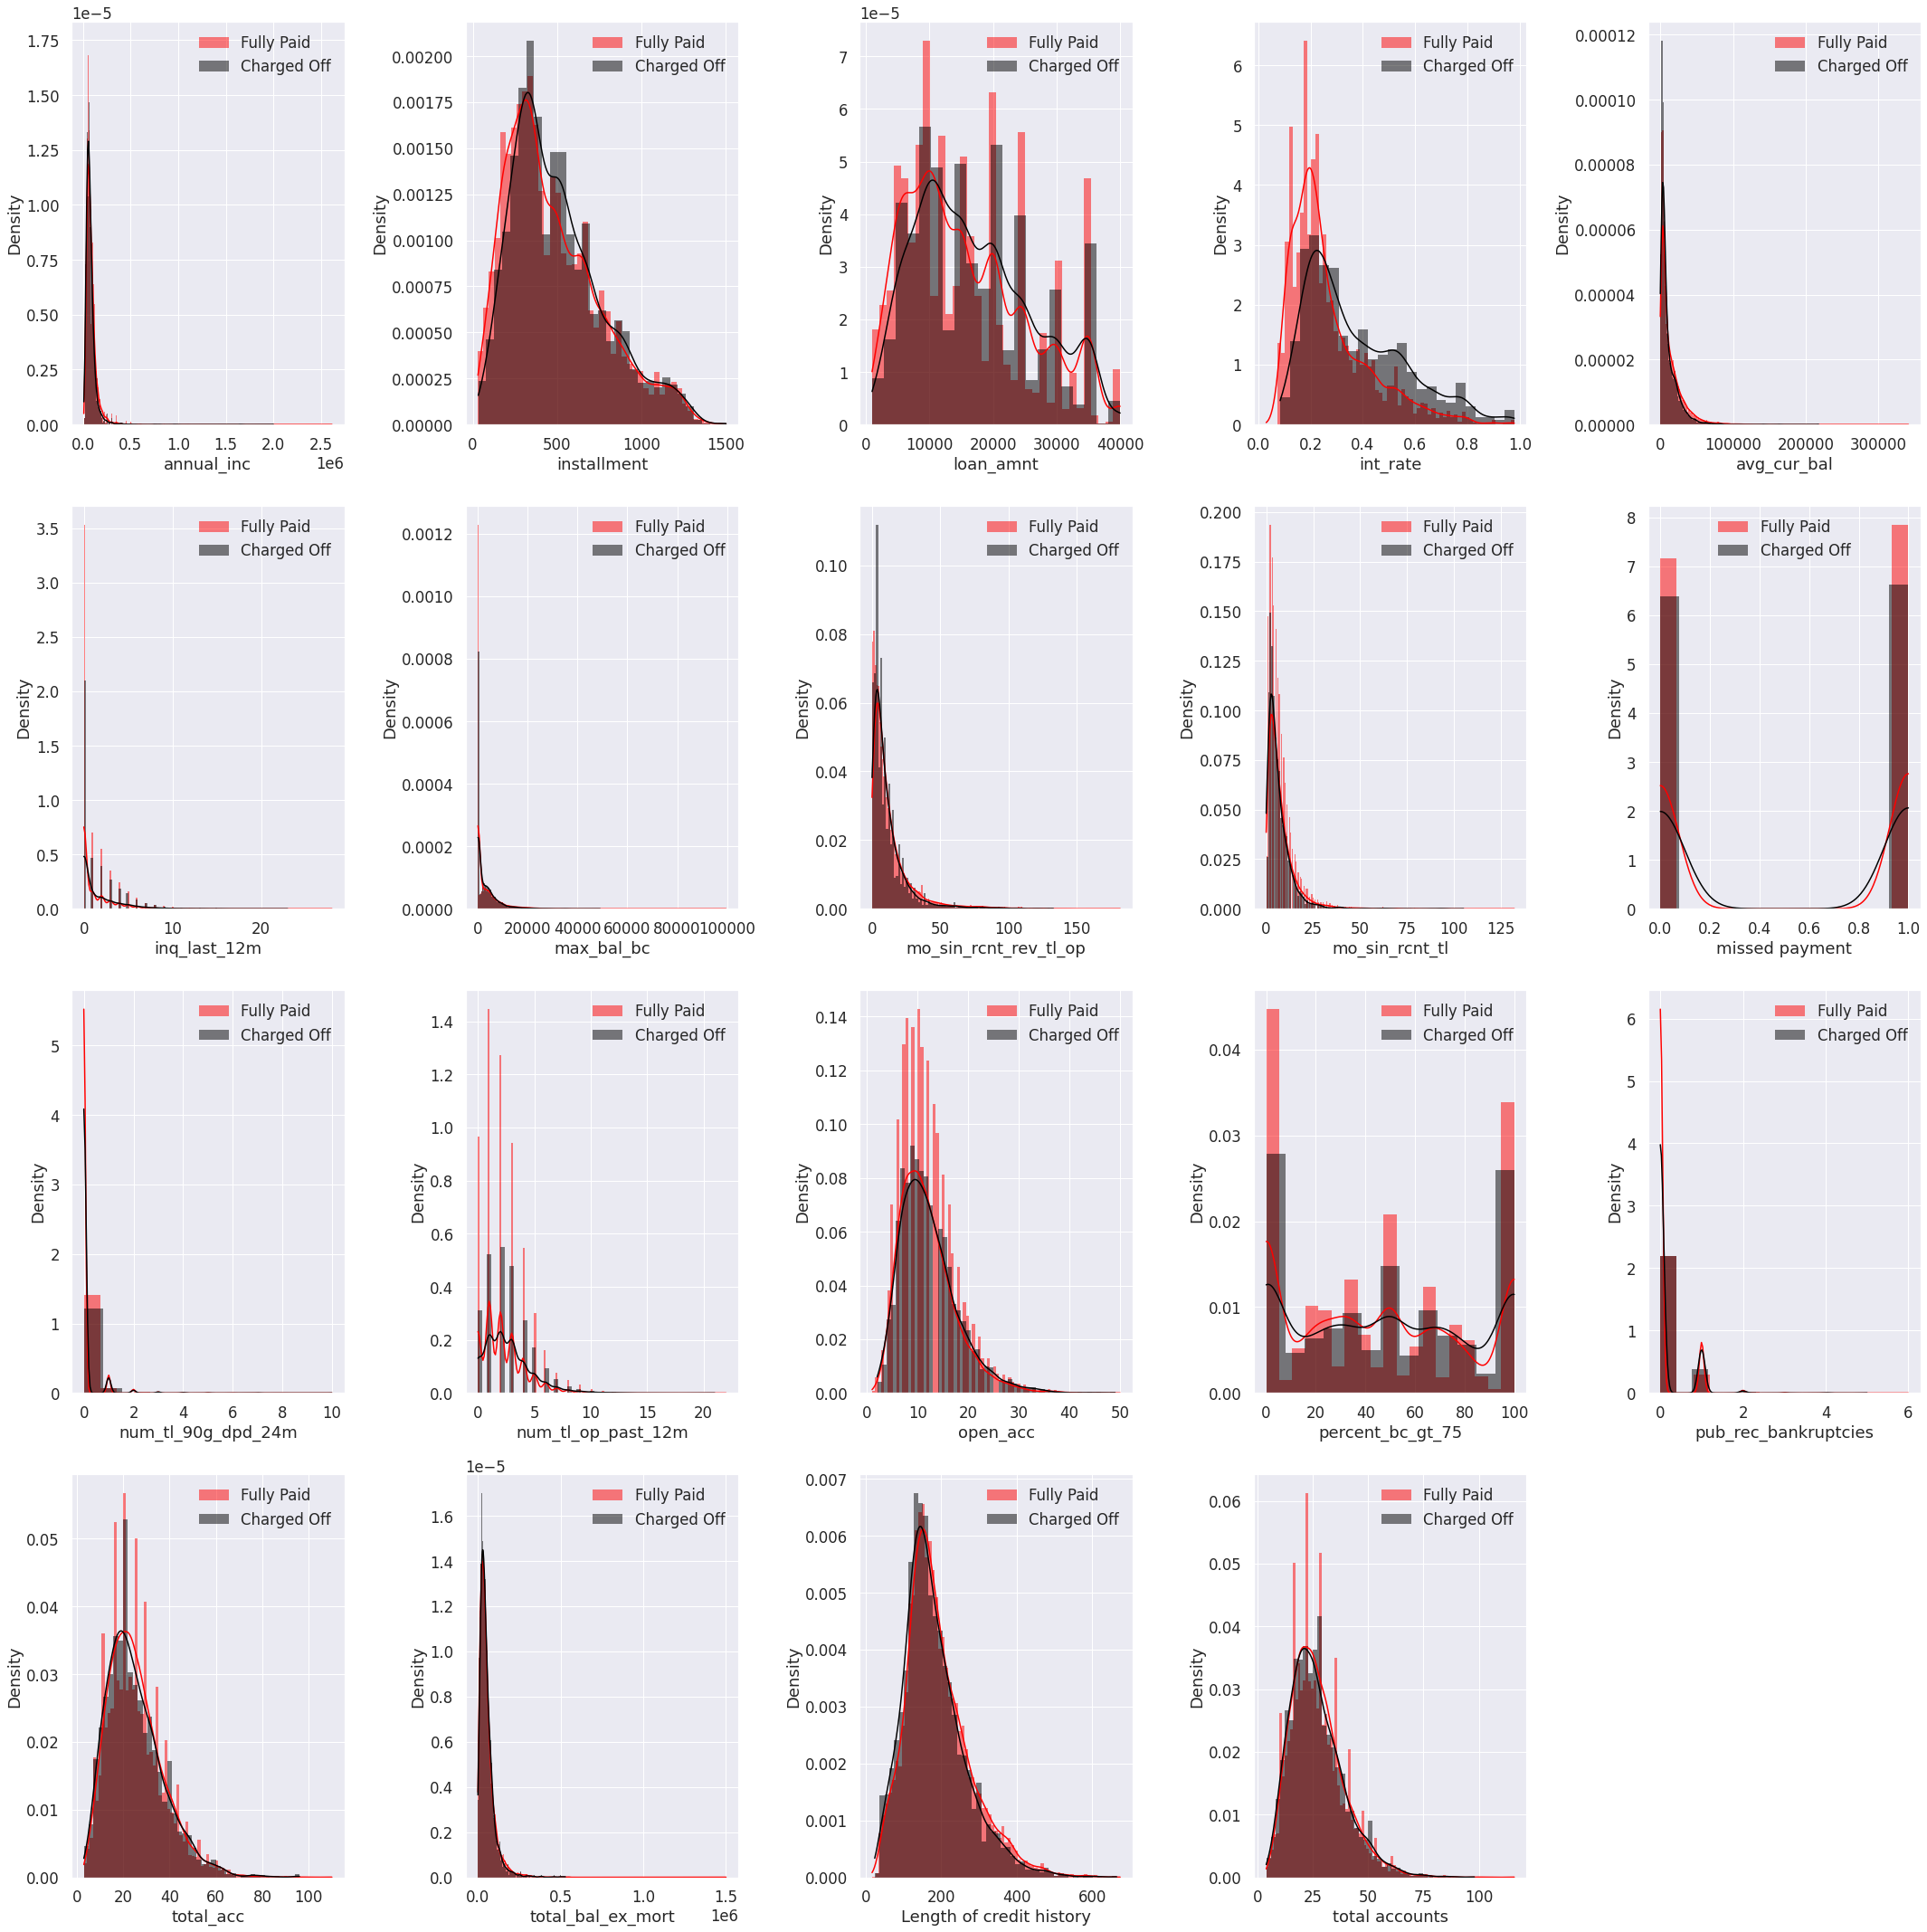

In [26]:
paid = data[data['loan_status']=='Fully Paid']
not_paid = data[data['loan_status']=='Charged Off']
plt.figure(figsize=(30,30))
i = 1 

for col in numerical_features: 
    ax = plt.subplot(4,5,i)
    sns.histplot(paid[col], color="red", label='Fully Paid', kde=True, stat="density", linewidth=0)
    sns.histplot(not_paid[col], color="black", label='Charged Off', kde=True, stat="density", linewidth=0)
    plt.legend()
    i+=1
plt.tight_layout()
plt.show()

- **The distributions of those who paid off their loan and those who didn't are very close to each other.**

- **Higher interest rate on the loan seems to lead to a default.**

In [27]:
## check for duplicates
data[data.duplicated(keep='first')].shape

(0, 26)

In [28]:
## binary target from string to integer
data['loan_status'].replace({'Charged Off':0, 'Fully Paid':1}, inplace=True)

**Barplots of categorical features based on the corresponding mean value of the target variable.**

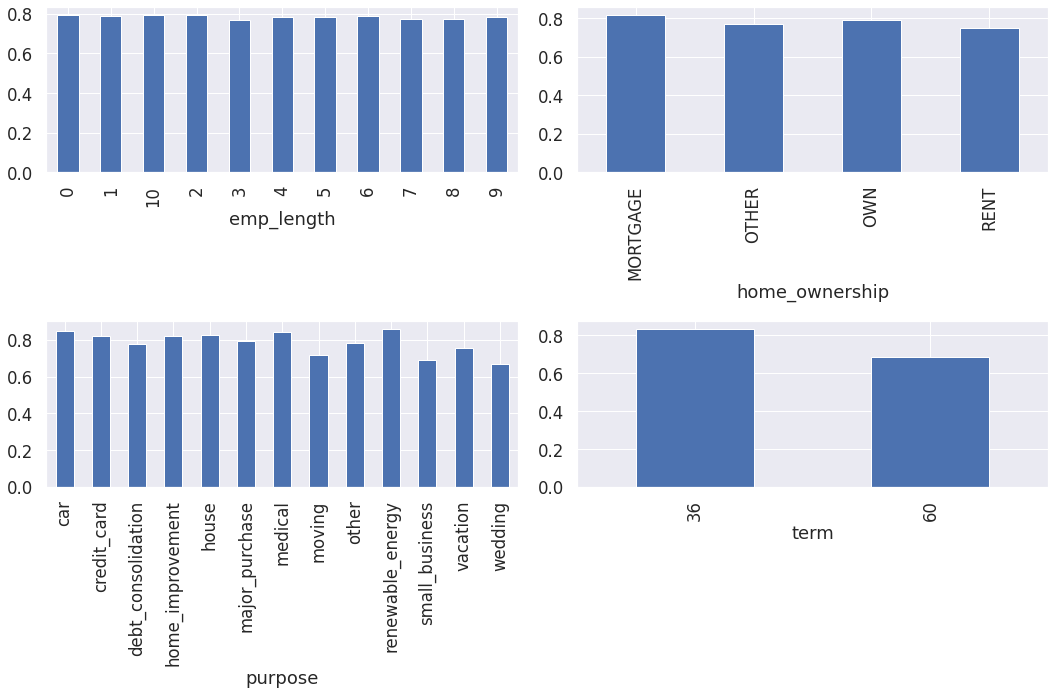

In [29]:
colsejcmm = ['emp_length','home_ownership', 'purpose', 'term']
plt.figure(figsize=(15,10))
i = 1 
for col in colsejcmm:
  ax = plt.subplot(2,2,i)
  data.groupby([col])['loan_status'].mean().plot.bar()
  i+=1
plt.tight_layout()
plt.show()

- **Let's convert the term and emp_length to numeric.**

In [30]:
data['term'].replace({'36': 1, '60': 0}, inplace=True)
data['emp_length'] = pd.to_numeric(data['emp_length'], errors='coerce').convert_dtypes() 
data['emp_length'] = data['emp_length'].astype(int)

**Numerical vs Numerical feature pairplot.**

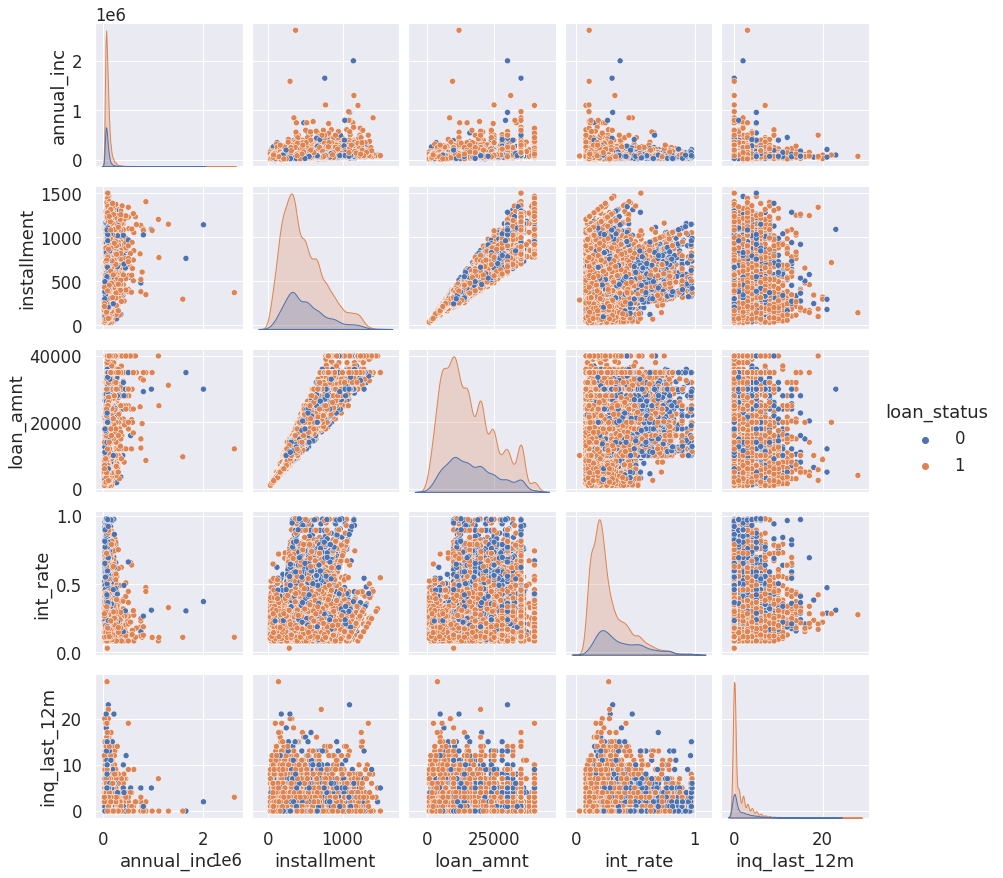

In [31]:
pairplot_df = data[['annual_inc','installment','loan_amnt','int_rate','inq_last_12m','loan_status']]
sns.pairplot(data=pairplot_df,hue='loan_status')

- **There is one clear linear relationship. The loan amount and the interest rate.** 

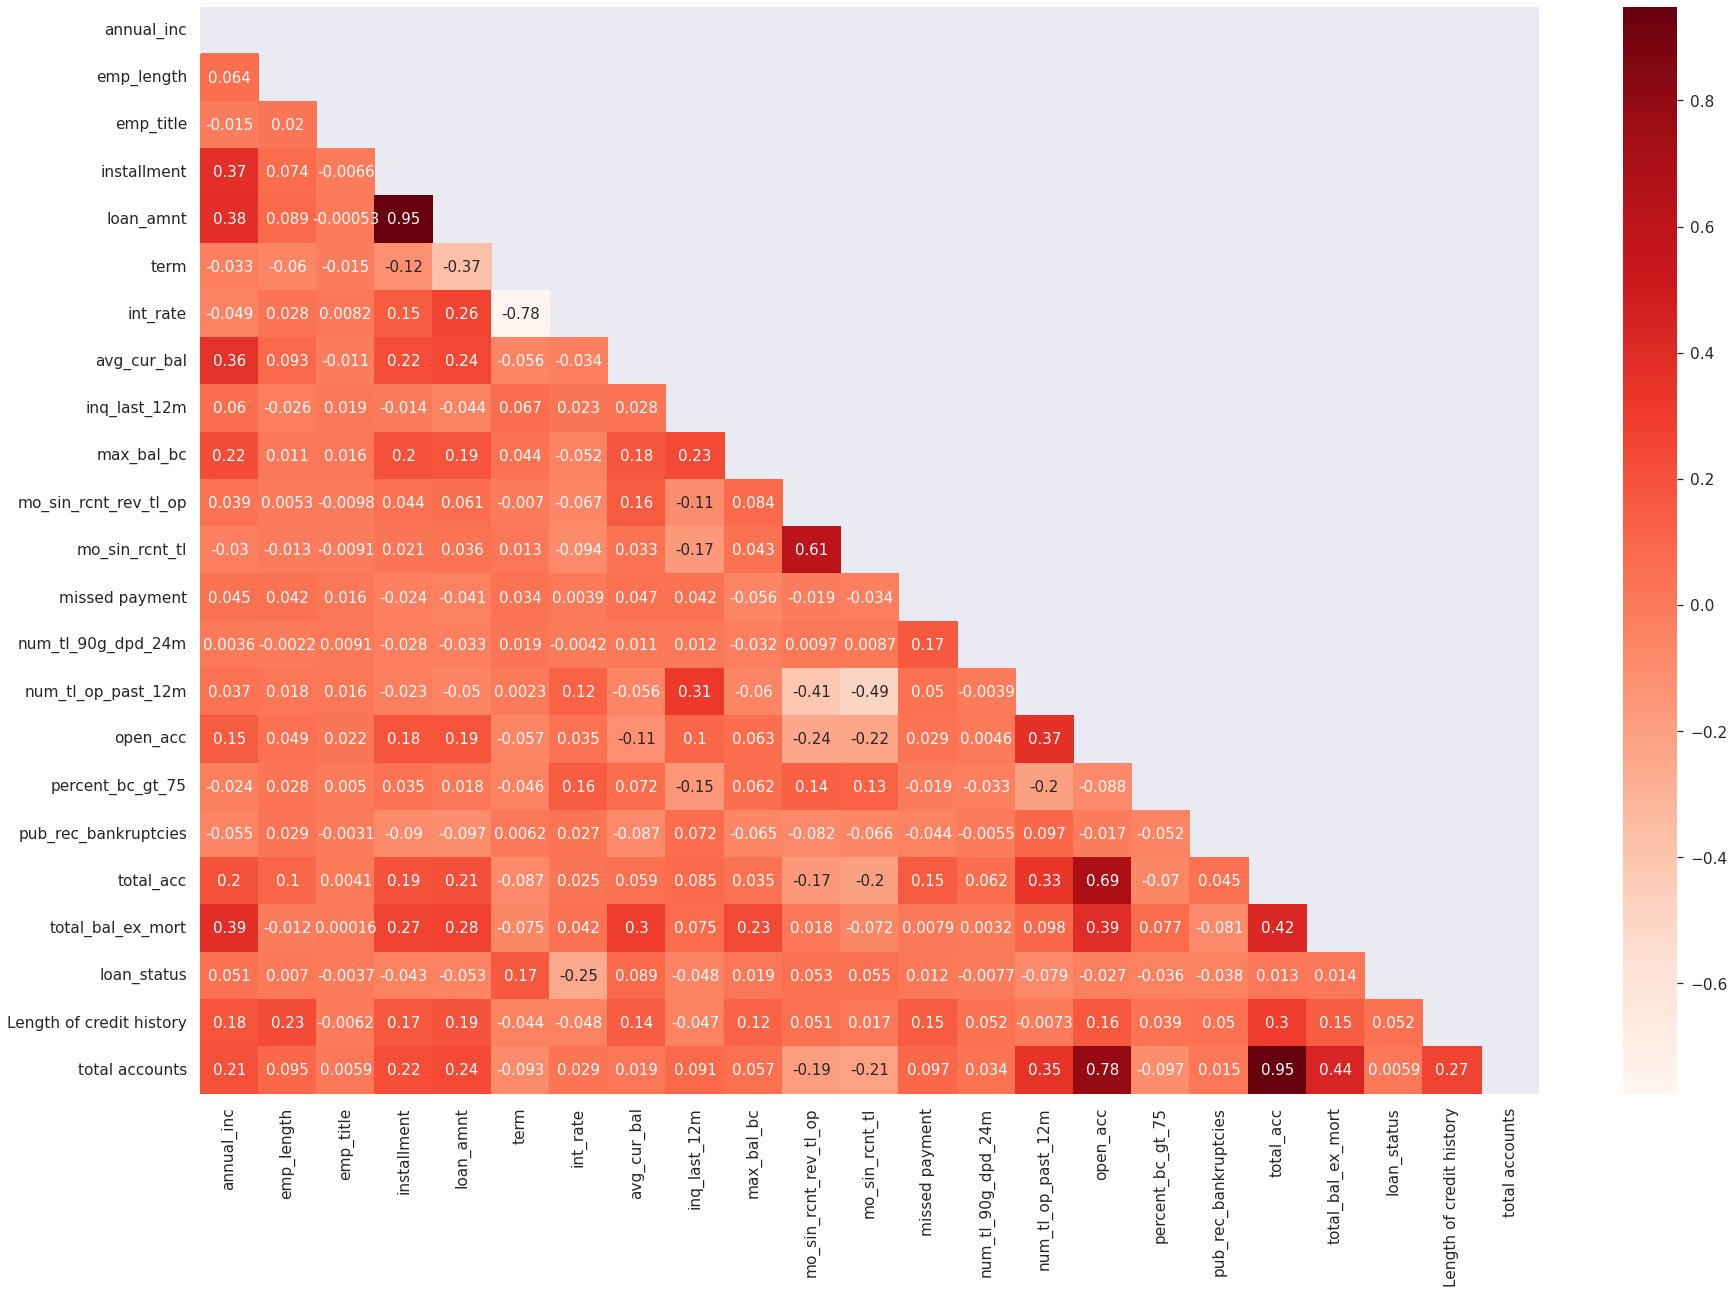

In [32]:
## Correlation Heatmap

sns.set(font_scale=1.4)
# correlation 
cor = data.corr('pearson')
matrix = np.triu(cor)

# heatmap to visualise the correlation
plt.figure(figsize=(30,20))
sns.heatmap(cor,annot=True, cmap=plt.cm.Reds, mask=matrix,annot_kws={'size': 15})
plt.show()

- **There are some highly positively/negatively correlated features.(e.g. total accounts with the number of open credit lines / number of accounts 90 or more days past due in the last 12 months with months since most recent revolving account opened)**

- **The term and interest rate variables seem to be positively and negatively correlated with the target variable respectively.**

- **Will term and interest rate be the variables that contribute the most in predicting who will default?**

**Let's check for imbalanced data.**


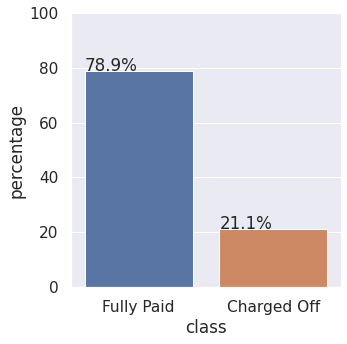

In [33]:
## Check for imbalanced data
df_ = data['loan_status'].value_counts(normalize=True)
df_ = df_.mul(100)
df_ = df_.rename('percentage').reset_index()
df_['class'] = ['Fully Paid','Charged Off']
g = sns.catplot(x='class',y='percentage',kind='bar',data=df_)
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

- Our target variable is **highly imbalanced**.
- **Major class: Fully Paid**.
- **Minor class: Charged Off**.

- To deal with the imbalanced data we will use the **SMOTE** (Synthetic Minority Oversampling TEchnique).

**A brief explanation of how SMOTE works:**

1. Calculate the distance, **d**, between two data points of the minority class.
2. Multiply **d** with a random number between $0$ and $1$.
3. The new feature vector is the new data point.

Note: We can repeat step 2. multiple times if we need more data points.

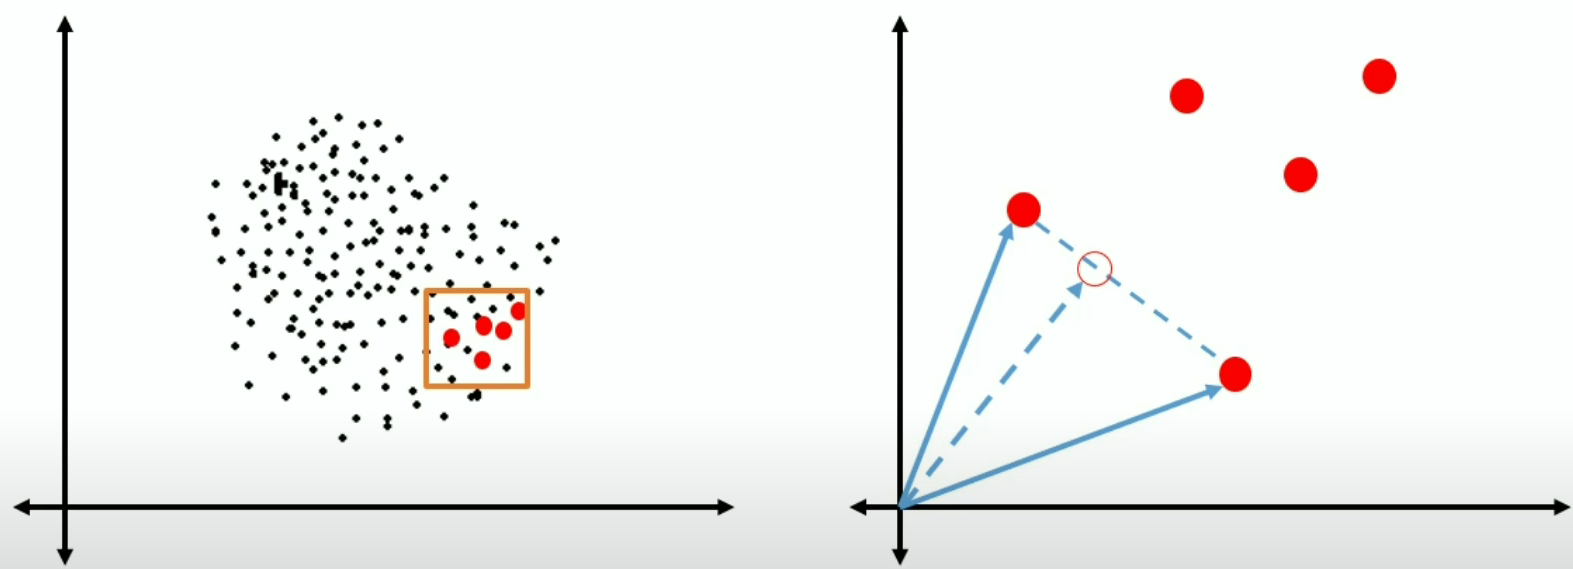

In [34]:
cat_features = ['addr_state', 'home_ownership', 'purpose', 'term', 'loan_status', 'emp_title']

In [35]:
numerical_features += ['emp_length']

In [36]:
data = data.reset_index(drop=True)

In [37]:
## Standard Scale to deal with the different scales of the features

d = data.copy()
d.drop(cat_features,axis=1,inplace=True)
d_scaled = preprocessing.StandardScaler().fit_transform(d)
d_scaled = pd.DataFrame(d_scaled, columns=numerical_features)


d_scaled = d_scaled.reset_index(drop=True)
for col in cat_features:
  d_scaled[col] = data[col]  

In [38]:
data_ = d_scaled.copy()

In [39]:
## onehotencoding the categorical features
data_ = pd.get_dummies(data_)
print(data_.shape)

(15955, 91)


In [40]:
data_.head()

,annual_inc,installment,loan_amnt,int_rate,avg_cur_bal,inq_last_12m,max_bal_bc,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,missed payment,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,0.21,-1.37,1.73,2.02,2.18,-0.41,-0.57,-0.62,0.94,0.17,...,0,0,0,0,0,0,0,0,0,0
1,0.54,-1.37,1.16,0.96,-0.78,-0.54,-0.57,-0.62,4.18,0.41,...,0,0,0,0,0,0,0,0,0,0
2,0.69,1.06,1.30,0.98,-0.50,0.24,-0.57,-0.62,3.43,-0.66,...,0,0,0,0,0,0,0,0,0,0
3,-0.37,1.06,-1.57,-1.58,-0.23,-0.09,-0.11,1.41,0.32,1.25,...,0,0,0,0,0,1,0,0,0,0
4,0.05,-1.64,0.53,0.85,1.69,-0.48,-0.57,-0.62,-0.74,-0.78,...,0,0,0,0,0,0,0,0,0,0


Let's now use **SHAP** to determine the **importance of each feature**.

In [41]:
df = data_.copy()
y = df['loan_status'] ## response 
X = df.drop('loan_status',axis=1) ## design matrix

X_train, X_test, y_train, y_test = train_test_split(X, ## features to split
                                                    y, ## response to split
                                                    test_size=0.2, ## we will leave 20% to test our models on later. 
                                                    random_state=2, ## make our work reproducible
                                                    stratify = y)  ## same amount of ppl who fully paid/charged off in the training and test set


sm = SMOTE(random_state=2)
rf = DecisionTreeClassifier(random_state=2)

X_train, y_train = sm.fit_resample(X_train, y_train)
rf.fit(X_train,y_train)
explainer = shap.TreeExplainer(rf)

## Shap values are arrays of a length corresponding to the number of classes in target.
## Here, we have 2 classes.
shap_values = explainer.shap_values(X_test)

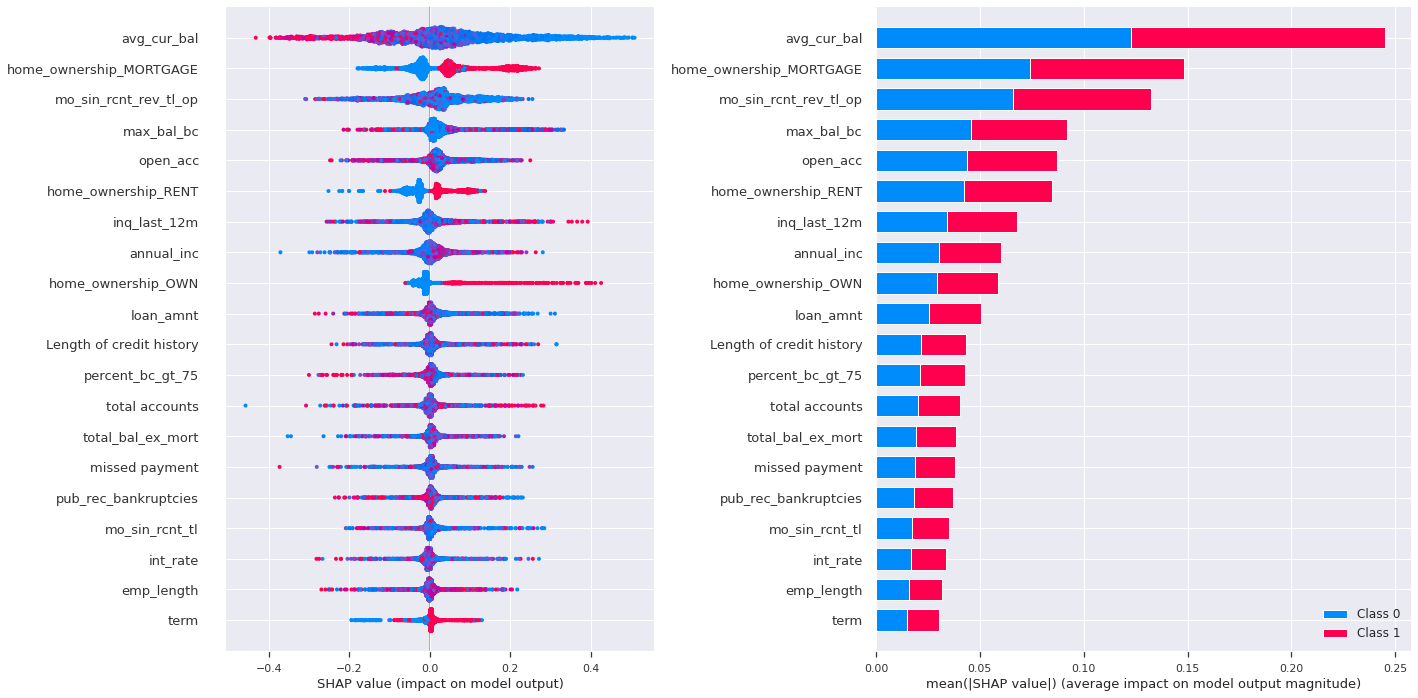

In [42]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
shap.summary_plot(shap_values[1], X_test, plot_size=None,show=False)
plt.subplot(1,2,2)
shap.summary_plot(shap_values, X_test, plot_type="bar", plot_size=None,show=False)
plt.tight_layout()
plt.show() 

- **The most important features after all are the Average current balance of all current credit lending products/accounts and the customer having a home mortgage.**

- **Next, we use the lazypredict library to try different basic models with different random states.**

In [43]:
# ## split the data frame into the response variable, y, and the design matrix, X
# df = data_.copy()
# y = df['loan_status'] ## response 
# X = df.drop('loan_status',axis=1) ## design matrix


# ## split the data into training and test data sets
# ## use different random states
# p = pd.DataFrame(columns=['Random_State','Model','F1 Score'])
# for i in range(5):
#     X_train, X_test, y_train, y_test = train_test_split(X, ## features to split
#                                                         y, ## response to split
#                                                         test_size=0.2, ## we will leave 20% to test our models on later. 
#                                                         random_state=i, ## make our work reproducible
#                                                        # shuffle=True,  ## prevent data ordering affecting our models
#                                                         stratify = y)  ## same amount of ppl who fully paid/charged off in the training and test set

#     basic_clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
#     models,predictions = basic_clf.fit(X_train, X_test, y_train, y_test)
#     best_models = models.sort_values(by=['F1 Score'], ascending=False).index.tolist()
#     acc = models.sort_values(by=['F1 Score'], ascending=False)['F1 Score'].iloc[0]
#     p = p.append({'Random_State': i, 'Model' : best_models[0], 'F1 Score' : acc}, ignore_index=True)

100%|██████████| 29/29 [02:02<00:00,  4.23s/it]


- The above cell takes some time to run so I will comment it out. Run it again if you want to make sure which models have the best F1 score.

In [44]:
# p.sort_values(by=['F1 Score'], ascending=False)[:5]

,Random_State,Model,F1 Score
4,4,BernoulliNB,0.76
0,0,BernoulliNB,0.75
3,3,BernoulliNB,0.75
1,1,BernoulliNB,0.75
2,2,BernoulliNB,0.74


- **BernoulliNB seems to be the 'best' model based on F1 Score.**


In [45]:
## Use only the most important features
df = data_.copy()
df_final = df[['avg_cur_bal', 
              
               'loan_status']].copy()


In [46]:
y = df_final['loan_status'] ## response 
X = df_final.drop('loan_status',axis=1) ## design matrix


## split the data into training and test data sets

X_train, X_test, y_train, y_test = train_test_split(X, ## features to split
                                                    y, ## response to split
                                                    test_size=0.2, ## we will leave 20% to test our models on later. 
                                                    random_state=2, ## make our work reproducible
                                                    stratify=y) 

In [47]:
## SMOTE to deal with the imbalance in the data
pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=2)],
                                ["nb", BernoulliNB()]])

In [48]:
## a 5k-fold cross validation
stratified_kfold = StratifiedKFold(n_splits=5,
                                  shuffle=True,
                                  random_state=2)

In [49]:
## a parameter grid to tune our model
param_grid = {'nb__alpha': [0.,.001,0.01,0.1],
    "nb__binarize": np.logspace(0, 5, 20)} 

In [50]:
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='average_precision',
                           cv=stratified_kfold,
                           n_jobs=-1)

In [51]:
## search for the best estimator
model_nb = grid_search.fit(X_train, y_train)
print(model_nb.best_params_)

{'nb__alpha': 0.0, 'nb__binarize': 1.0}


Balanced accuracy score:  0.5895
Precision score: 0.7356
Recall score: 0.7593
Classification Report : 
              precision    recall  f1-score   support

           0       0.40      0.30      0.34       673
           1       0.82      0.88      0.85      2518

    accuracy                           0.76      3191
   macro avg       0.61      0.59      0.60      3191
weighted avg       0.74      0.76      0.74      3191



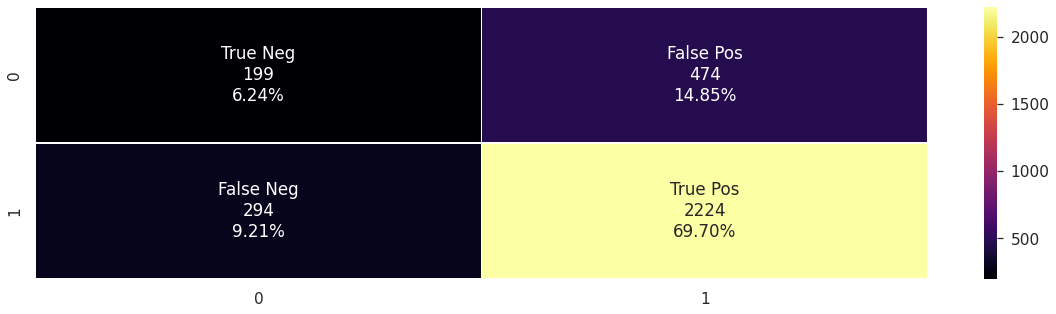

In [52]:
## train the model using the best estimator
pipe = model_nb.best_estimator_
model = pipe.fit(X_train, y_train)

threshold = 0.55
predicted = model.predict_proba(X_test)
predicted = (predicted[:,1] >= threshold).astype('int')

## predictions
y_pred = predicted

## HEATMAP-CONFUSION MATRIX
plt.figure(figsize=(20,5))
cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='inferno',linewidths=0.3)

## metric scores on test set
print(f"Balanced accuracy score: {balanced_accuracy_score(y_test, y_pred): .4f}")
print(f"Precision score: {precision_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Recall score: {recall_score(y_test, y_pred, average='weighted'):.4f}")

## classification report
clf_report = classification_report(y_test, y_pred)

print(f"Classification Report : \n{clf_report}")

**Observations:**

- The model has an accuracy of 76%, but we should focus on the precision, recall and F1-scores of each class.

- Both precision and recall of the major class (Fully Paid) are quite high, 82% and 88% respectively. This means that our model can detect 82% of those who will fully pay their loan with 88% precision. 

- On the other hand, both recall and precision of the minor class (Charged Off) are quite low, 30% and 40% respectively. This means that only about 30% of those who will default will be detected by our model. Also, around 60% of our model's predictions will be wrong.

**Overall:**
- Our model is very good at predicting those who will fully pay their loan, but it is not so good at predicting if someone will default their loan.

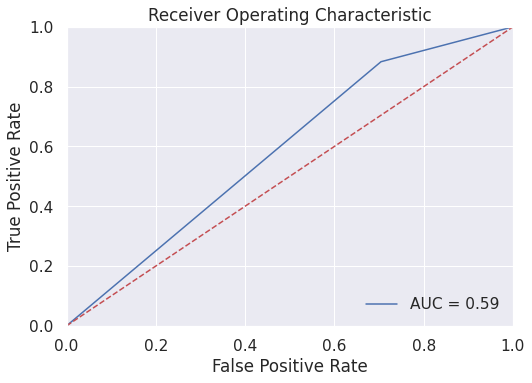

In [53]:
fpr, tpr, threshold = metrics.roc_curve(y_test, predicted)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**We can examine each prediction individually using SHAP.**

In [54]:
rf = DecisionTreeClassifier(random_state=2)

X_train, y_train = sm.fit_resample(X_train, y_train)
rf.fit(X_train,y_train)
explainer = shap.TreeExplainer(rf)

## Shap values are arrays of a length corresponding to the number of classes in target.
## Here, we have 2 classes.
shap_values = explainer.shap_values(X_test)

In [55]:
# # Initialize JavaScript visualizations in notebook environment
shap.initjs()
k = 10 ## controls which row to examine
print(f'The label for row {k} in the test set is: {y_test.iloc[k]}')
shap.force_plot(explainer.expected_value[1], shap_values[1][k], X_test.iloc[k])

The label for row 10 in the test set is: 1


**Let's cluster the customers.**

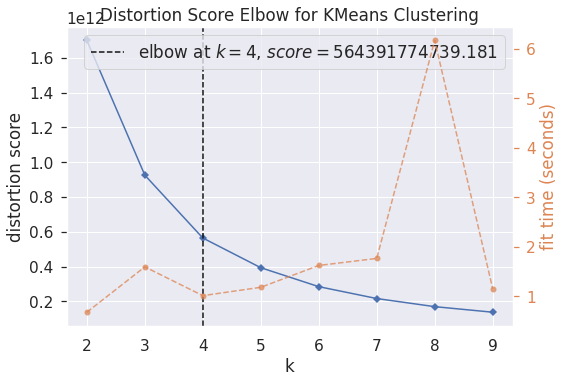

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f90e761eb50>,
                 estimator=KMeans(n_clusters=9, random_state=2), k=(2, 10))

In [56]:
X_ = data[['avg_cur_bal','loan_status']].copy()
kelbow_visualizer(KMeans(random_state=2), X_, k=(2,10))

In [57]:
kmeans = KMeans(n_clusters=4, random_state=2).fit(X_)
y_kmeans= kmeans.predict(X_)
X_['cluster'] = y_kmeans

In [58]:
X_.head()

,avg_cur_bal,loan_status,cluster
0,7019,1,2
1,4891,1,2
2,17619,1,0
3,12321,1,2
4,5896,0,2


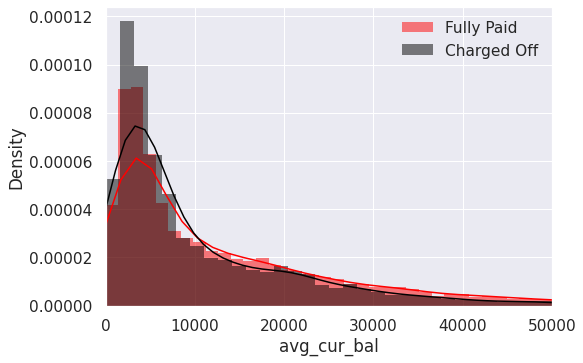

In [59]:
paid = X_[X_['loan_status']==1]
not_paid = X_[X_['loan_status']==0]

sns.histplot(paid['avg_cur_bal'], color="red", label='Fully Paid', kde=True, stat="density", linewidth=0)
sns.histplot(not_paid['avg_cur_bal'], color="black", label='Charged Off', kde=True, stat="density", linewidth=0)
plt.xlim((0,50000))
plt.legend()
plt.show()

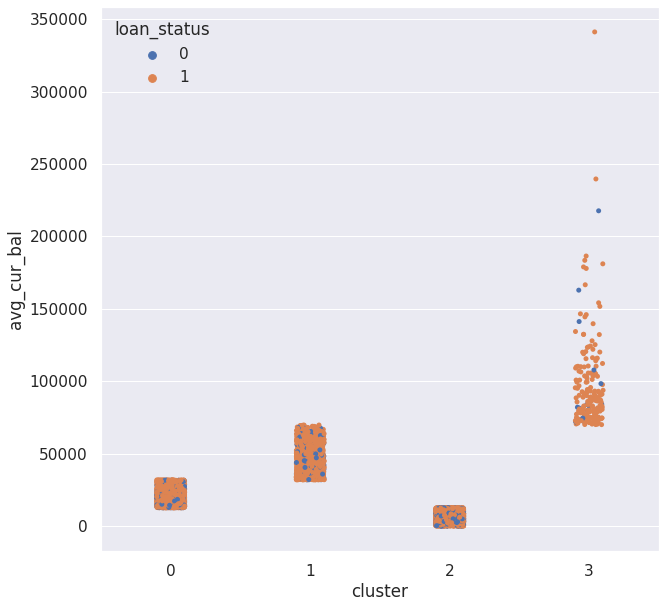

In [60]:
plt.figure(figsize=(10,10))
sns.stripplot(data=X_,x='cluster',y='avg_cur_bal', hue='loan_status')

In [61]:
cluster = 'cluster'
avg = 'avg_cur_bal'
for i in range(4):
    print(f'Cluster {i}: Min Avg current balance : {X_[X_[cluster]==i][avg].min()}')
    print(f'Cluster {i}: Max Avg current balance : {X_[X_[cluster]==i][avg].max()}')
    print('-----------------------------------------------------------------------')

Cluster 0: Min Avg current balance : 12657
Cluster 0: Max Avg current balance : 31893
-----------------------------------------------------------------------
Cluster 1: Min Avg current balance : 31909
Cluster 1: Max Avg current balance : 69782
-----------------------------------------------------------------------
Cluster 2: Min Avg current balance : 0
Cluster 2: Max Avg current balance : 12653
-----------------------------------------------------------------------
Cluster 3: Min Avg current balance : 70063
Cluster 3: Max Avg current balance : 341236
-----------------------------------------------------------------------


- **Customers with an average current balance on all credit accounts of less than $32000 are more likely to default their loan.**

- **The vast majority of customers with an average current balance on all credit accounts of more than $70000 will not default their loan.**

More precisely: 

- Cluster 0: 18.5% will default their loan.
- Cluster 1: 13.05% will default their loan.
- Cluster 2: 23.65% will default their loan.
- Cluster 3: 7.88% will default their loan.

**We recommend the company to prefer giving loans to the customers that their  average current balance of all their credit accounts is high (greater than $32000).**